In [12]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression
from datetime import timedelta,datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp, linregress
from datetime import timedelta
import warnings
from scipy import stats

# Suppress all warnings
warnings.filterwarnings("ignore")

# Set display options for pandas
pd.options.display.max_columns = None

# Load the deals data
df_ma = pd.read_csv("XBI_Deals_CSV.csv")

# Convert 'Date Announced' to datetime format
df_ma['Date Announced'] = pd.to_datetime(df_ma['Date Announced'], format='%b-%y')

# Extract month and year from 'Date Announced'
df_ma['Month'] = df_ma['Date Announced'].dt.month
df_ma['Year'] = df_ma['Date Announced'].dt.year

# Create a clean copy of the DataFrame
df_clean = df_ma.copy()

# Number of deals , grouped by month 

#### Most deals in January and least deals in July. On averafe, largest deals happen in January and smallest deals happen in July. 
#### On average, largest 90-day premium comes in May and smallest premium comes in July.

All values are numeric: True


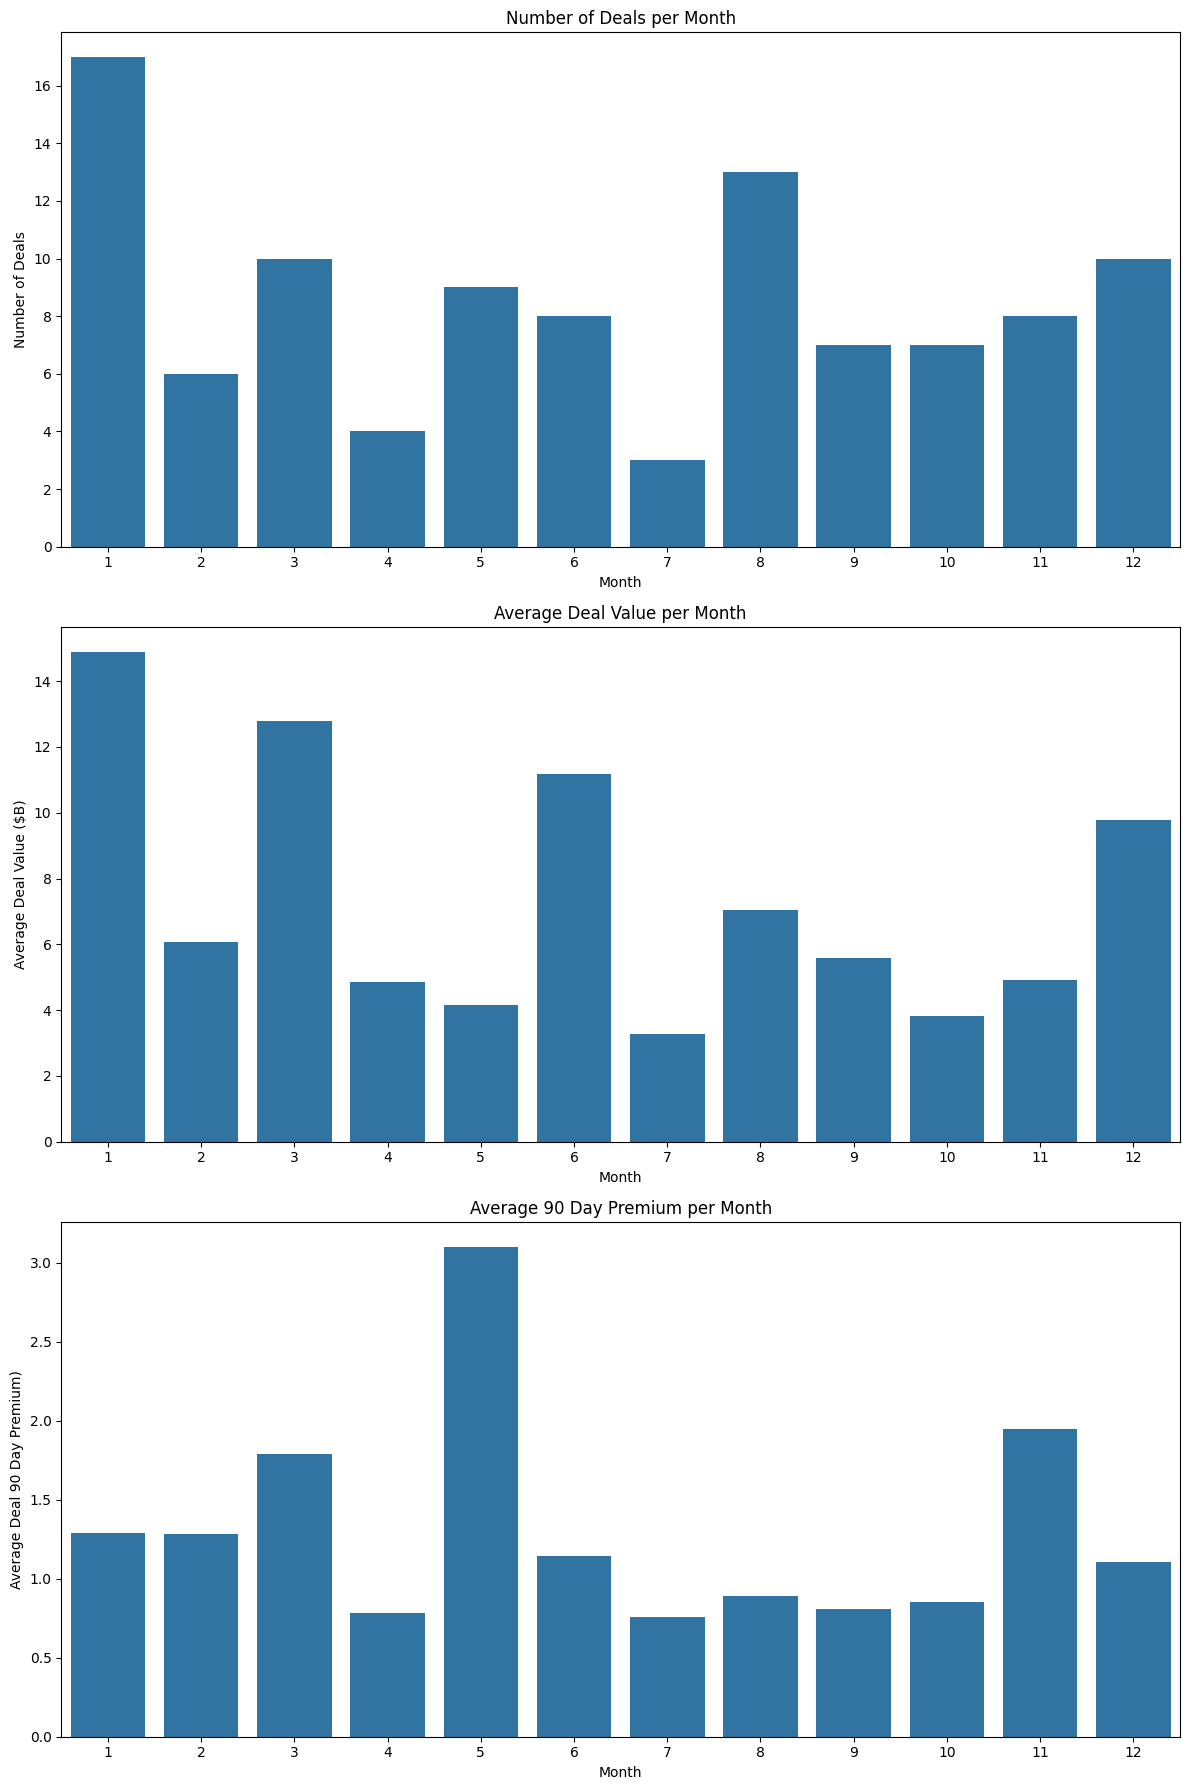

In [13]:
# Clean '90 Day Premium' data
df_clean_90 = df_clean.copy()
df_clean_90['90 Day Premium'] = df_clean_90['90 Day Premium'].replace('-', np.nan)
df_clean_90 = df_clean_90.dropna(subset=['90 Day Premium'])
df_clean_90['90 Day Premium'] = pd.to_numeric(df_clean_90['90 Day Premium'], errors='raise')

# Verify if all values are numeric in '90 Day Premium'
all_numeric = df_clean_90['90 Day Premium'].apply(lambda x: isinstance(x, (int, float))).all()
print("All values are numeric:", all_numeric)

# Analyze XBI seasonality - Number of deals per month
monthly_deals = df_clean_90.groupby('Month').size()

# Calculate total deal value per month
total_deal_value = df_clean_90.groupby('Month')['Deal Value \n($B)'].mean()

# Calculate average deal 90 day premium per month
average_deal_premium= df_clean_90.groupby('Month')['90 Day Premium'].mean()

# Plotting
plt.figure(figsize=(12, 18))

# 1. Number of Deals per Month
plt.subplot(3, 1, 1)
sns.barplot(x=monthly_deals.index, y=monthly_deals.values)
plt.xlabel('Month')
plt.ylabel('Number of Deals')
plt.title('Number of Deals per Month')
plt.xticks(rotation=0)
plt.tight_layout()

# 2. Average Deal Value per Month
plt.subplot(3, 1, 2)
sns.barplot(x=total_deal_value.index, y=total_deal_value.values)
plt.xlabel('Month')
plt.ylabel('Average Deal Value ($B)')
plt.title('Average Deal Value per Month')
plt.xticks(rotation=0)
plt.tight_layout()

# 3. Average Deal Premium per Month
plt.subplot(3, 1, 3)
sns.barplot(x=average_deal_premium.index, y=average_deal_premium.values)
plt.xlabel('Month')
plt.ylabel('Average Deal 90 Day Premium)')
plt.title('Average 90 Day Premium per Month')
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()


## Deal size vs 90 day Premium
#### Out of 15 years, 3 had positive slopes and 12 had negative slopes. The much greater number of negative slopes indicate that as the deal value increases, the 90-day premium tends to decrease. This could imply that larger deals might be perceived as less risky or have less market excitement, leading to a lower premium.

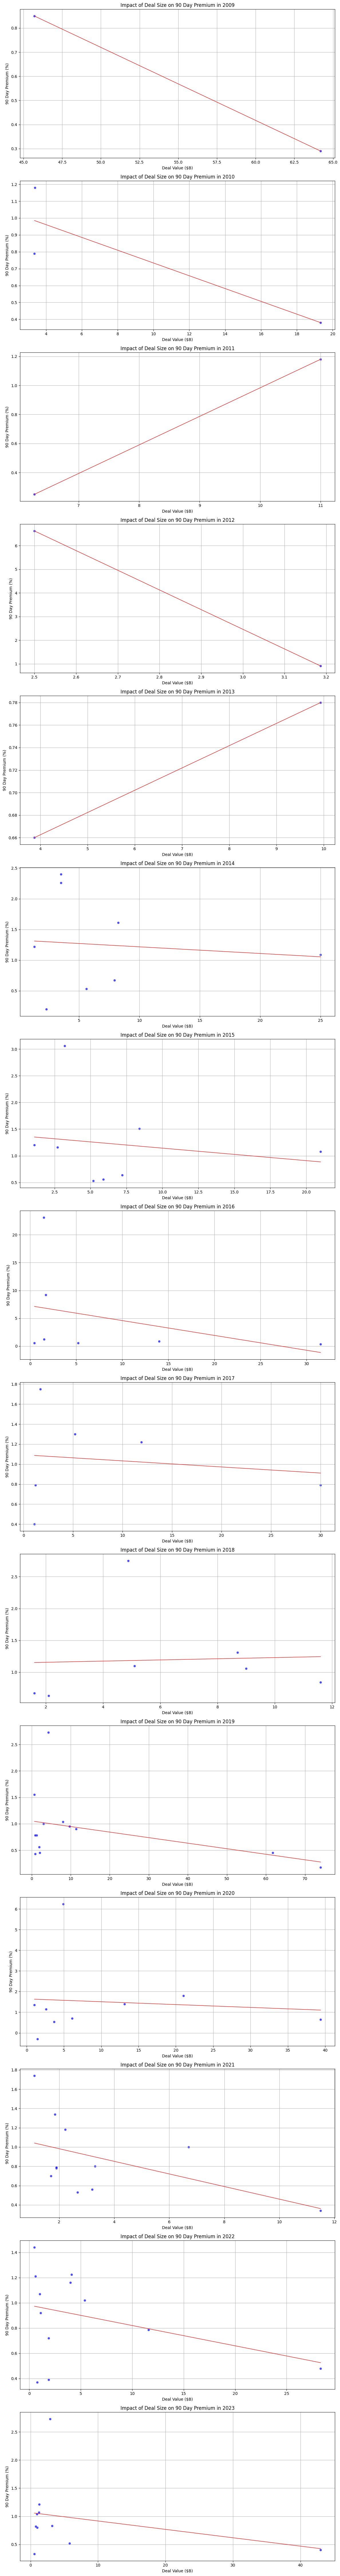

Out of 15 years, 3 had positive slopes and 12 had negative slopes. The much greater number of negative slopes indicate that as the deal value increases, the 90-day premium tends to decrease. This could imply that larger deals might be perceived as less risky or have less market excitement, leading to a lower premium.


In [14]:
# Get unique years from the dataset
years = df_clean_90['Year'].unique()

# Initialize counters for positive and negative slopes
positive_slopes = 0
negative_slopes = 0

# Create a figure with subplots for each year
num_years = len(years)
plt.figure(figsize=(12, 6 * num_years))

# Loop through each year and create a scatter plot with regression line
for i, year in enumerate(years):
    plt.subplot(num_years, 1, i + 1)  # Create a subplot for each year
    subset = df_clean_90[df_clean_90['Year'] == year]
    
    # Scatter plot for the year
    sns.scatterplot(data=subset, x='Deal Value \n($B)', y='90 Day Premium', 
                    alpha=0.7, color='blue')
    
    # Fit linear regression model
    X = subset[['Deal Value \n($B)']]
    y = subset['90 Day Premium']
    model = LinearRegression().fit(X, y)
    slope = model.coef_[0]  # Get the slope of the regression line
    
    # Count positive and negative slopes
    if slope > 0:
        positive_slopes += 1
    else:
        negative_slopes += 1
    
    # Regression line
    sns.regplot(data=subset, x='Deal Value \n($B)', y='90 Day Premium', 
                scatter=False, color='red', line_kws={'lw': 1}, ci=None)
    
    # Set labels and title for each subplot
    plt.xlabel('Deal Value ($B)')
    plt.ylabel('90 Day Premium (%)')
    plt.title(f'Impact of Deal Size on 90 Day Premium in {year}')
    plt.grid(True)

plt.tight_layout()
plt.show()

# Create a summary string
summary_string = f'Out of {num_years} years, {positive_slopes} had positive slopes and {negative_slopes} had negative slopes. The much greater number of negative slopes indicate that as the deal value increases, the 90-day premium tends to decrease. This could imply that larger deals might be perceived as less risky or have less market excitement, leading to a lower premium.'
print(summary_string)


## Advisors vs 90 day Premium & Deal Size
#### When RBC, Cowen, BofA serves as the financial advisor for the target, the 90-day premium typically rises. Conversely, when MTS, Citi, or JPM acts as the financial advisor for the acquirer, the 90-day premium also tends to be higher.

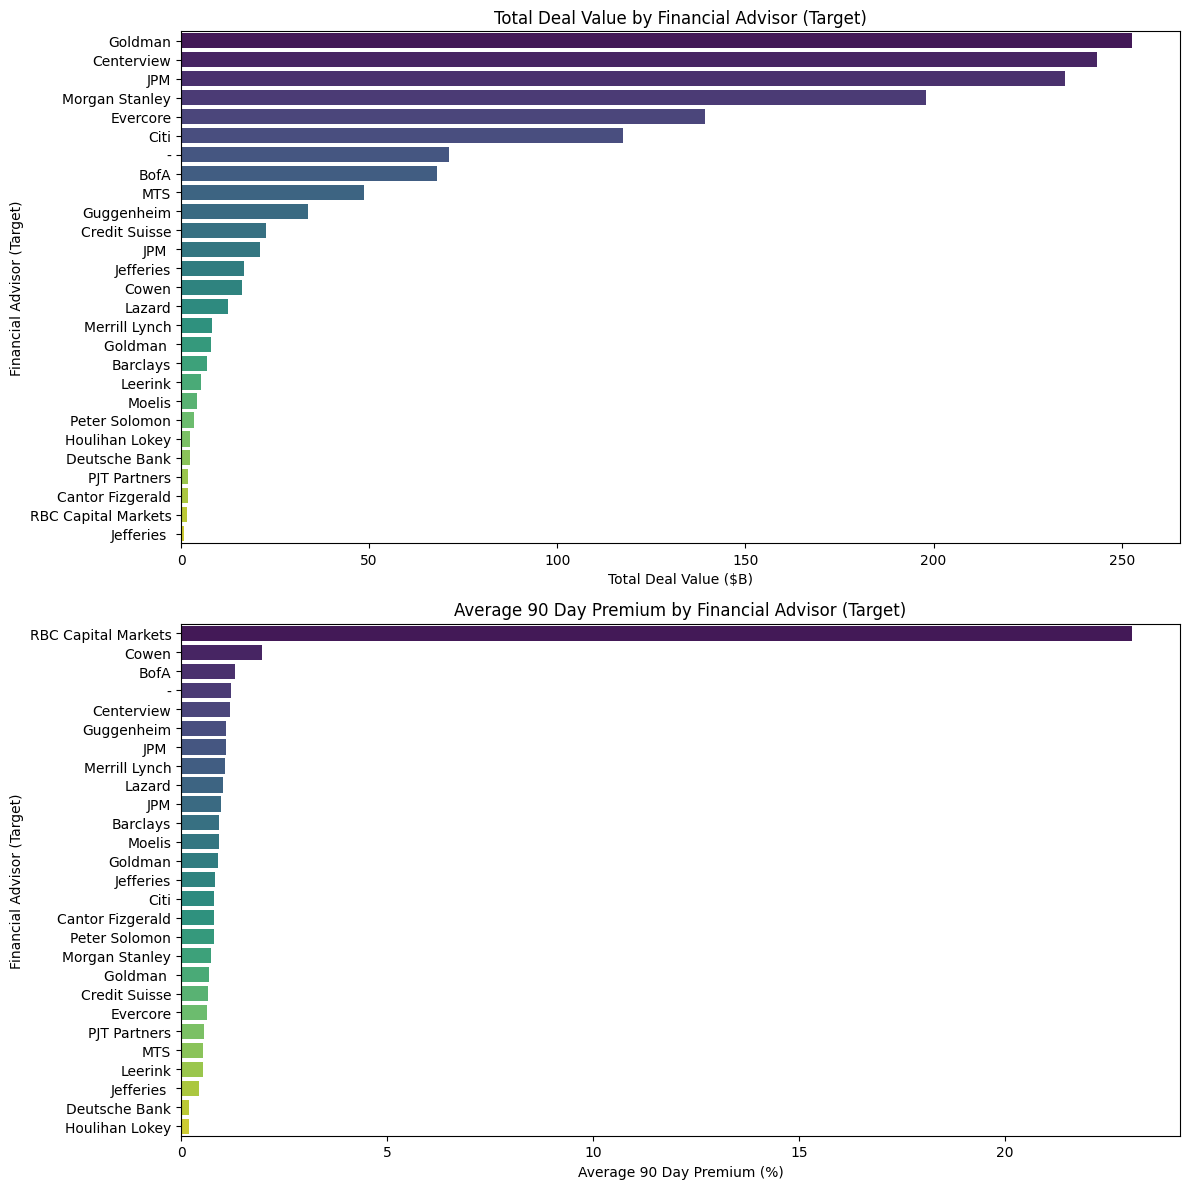

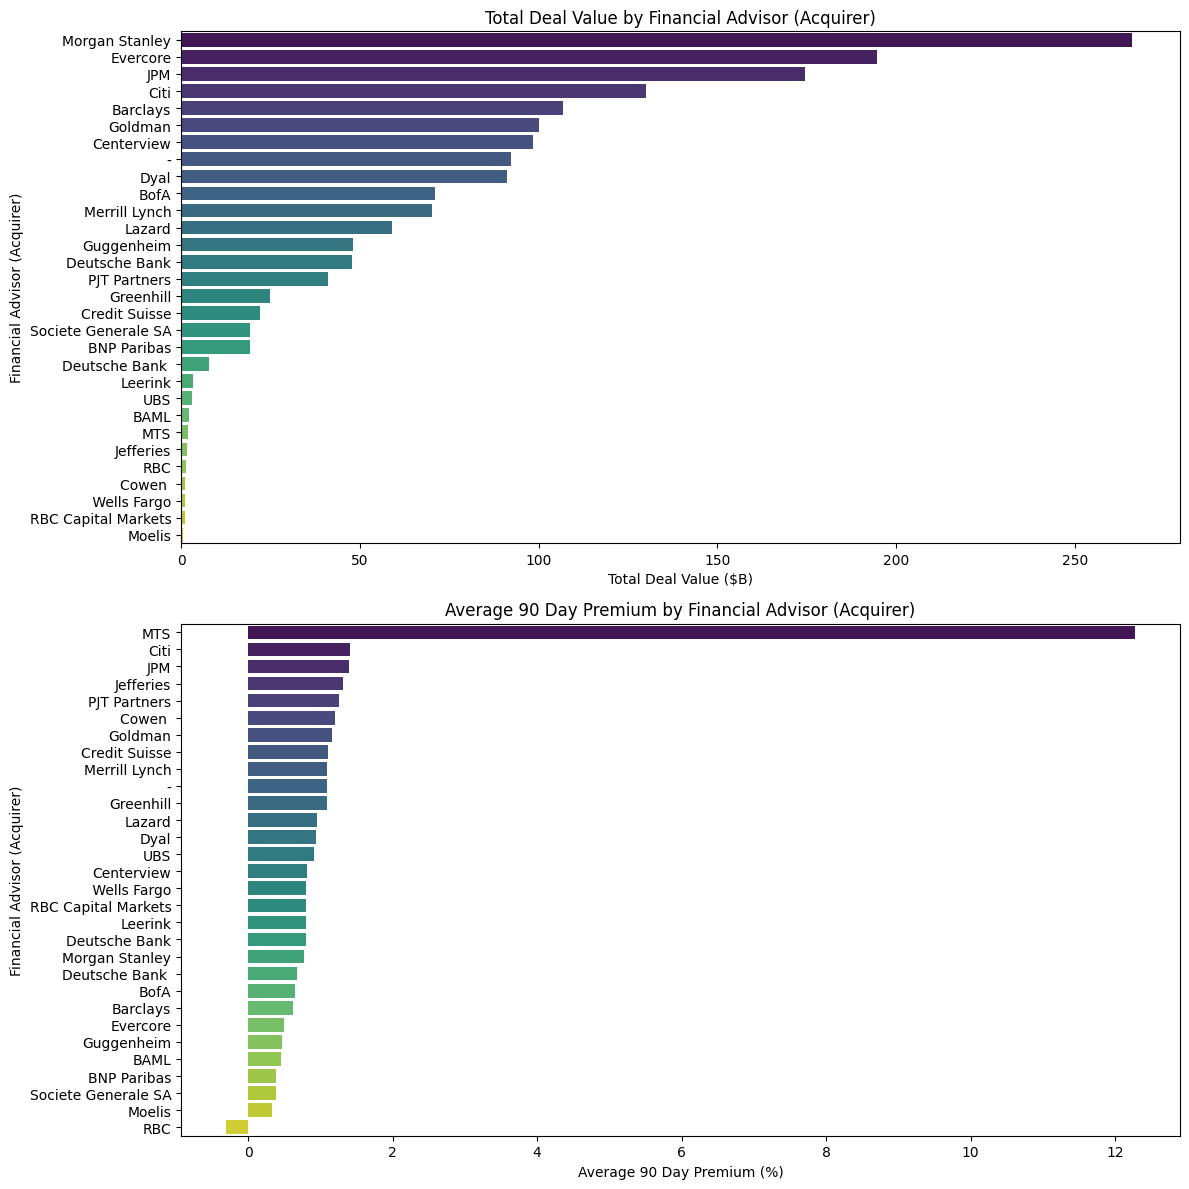

In [15]:
# Function to split multiple advisors and explode the DataFrame
def explode_advisors(df, advisor_column):
    # Split the advisor column by ',' and explode the DataFrame
    return df.assign(**{advisor_column: df[advisor_column].str.split(', ')}).explode(advisor_column)

# Explode the Financial Advisors columns
df_exploded_target = explode_advisors(df_clean_90, 'Financial Advisor (Target)')
df_exploded_acquirer = explode_advisors(df_clean_90, 'Financial Advisor (Acquirer)')

# Group by Financial Advisor (Target)
target_grouped = df_exploded_target.groupby('Financial Advisor (Target)').agg(
    Total_Deal_Value=('Deal Value \n($B)', 'sum'),
    Average_90_Day_Premium=('90 Day Premium', 'mean')
).reset_index()

# Group by Financial Advisor (Acquirer)
acquirer_grouped = df_exploded_acquirer.groupby('Financial Advisor (Acquirer)').agg(
    Total_Deal_Value=('Deal Value \n($B)', 'sum'),
    Average_90_Day_Premium=('90 Day Premium', 'mean')
).reset_index()

# Sort the grouped data for Target Advisors
target_grouped = target_grouped.sort_values(by='Total_Deal_Value', ascending=False)
acquirer_grouped = acquirer_grouped.sort_values(by='Total_Deal_Value', ascending=False)

# Plotting Total Deal Value and Average 90 Day Premium for Target Advisors
plt.figure(figsize=(12, 12))

# 1. Total Deal Value by Financial Advisor (Target)
plt.subplot(2, 1, 1)
sns.barplot(data=target_grouped, x='Total_Deal_Value', y='Financial Advisor (Target)', palette='viridis')
plt.xlabel('Total Deal Value ($B)')
plt.title('Total Deal Value by Financial Advisor (Target)')

# 2. Average 90 Day Premium by Financial Advisor (Target)
plt.subplot(2, 1, 2)
sns.barplot(data=target_grouped.sort_values(by='Average_90_Day_Premium', ascending=False), 
            x='Average_90_Day_Premium', y='Financial Advisor (Target)', palette='viridis')
plt.xlabel('Average 90 Day Premium (%)')
plt.title('Average 90 Day Premium by Financial Advisor (Target)')

plt.tight_layout()
plt.show()

# Plotting Total Deal Value and Average 90 Day Premium for Acquirer Advisors
plt.figure(figsize=(12, 12))

# 1. Total Deal Value by Financial Advisor (Acquirer)
plt.subplot(2, 1, 1)
sns.barplot(data=acquirer_grouped, x='Total_Deal_Value', y='Financial Advisor (Acquirer)', palette='viridis')
plt.xlabel('Total Deal Value ($B)')
plt.title('Total Deal Value by Financial Advisor (Acquirer)')

# 2. Average 90 Day Premium by Financial Advisor (Acquirer)
plt.subplot(2, 1, 2)
sns.barplot(data=acquirer_grouped.sort_values(by='Average_90_Day_Premium', ascending=False), 
            x='Average_90_Day_Premium', y='Financial Advisor (Acquirer)', palette='viridis')
plt.xlabel('Average 90 Day Premium (%)')
plt.title('Average 90 Day Premium by Financial Advisor (Acquirer)')

plt.tight_layout()
plt.show()


## Disease Category  vs 90 day Premium & Deal Size
#### Oncology commands the largest deals and deal premiums

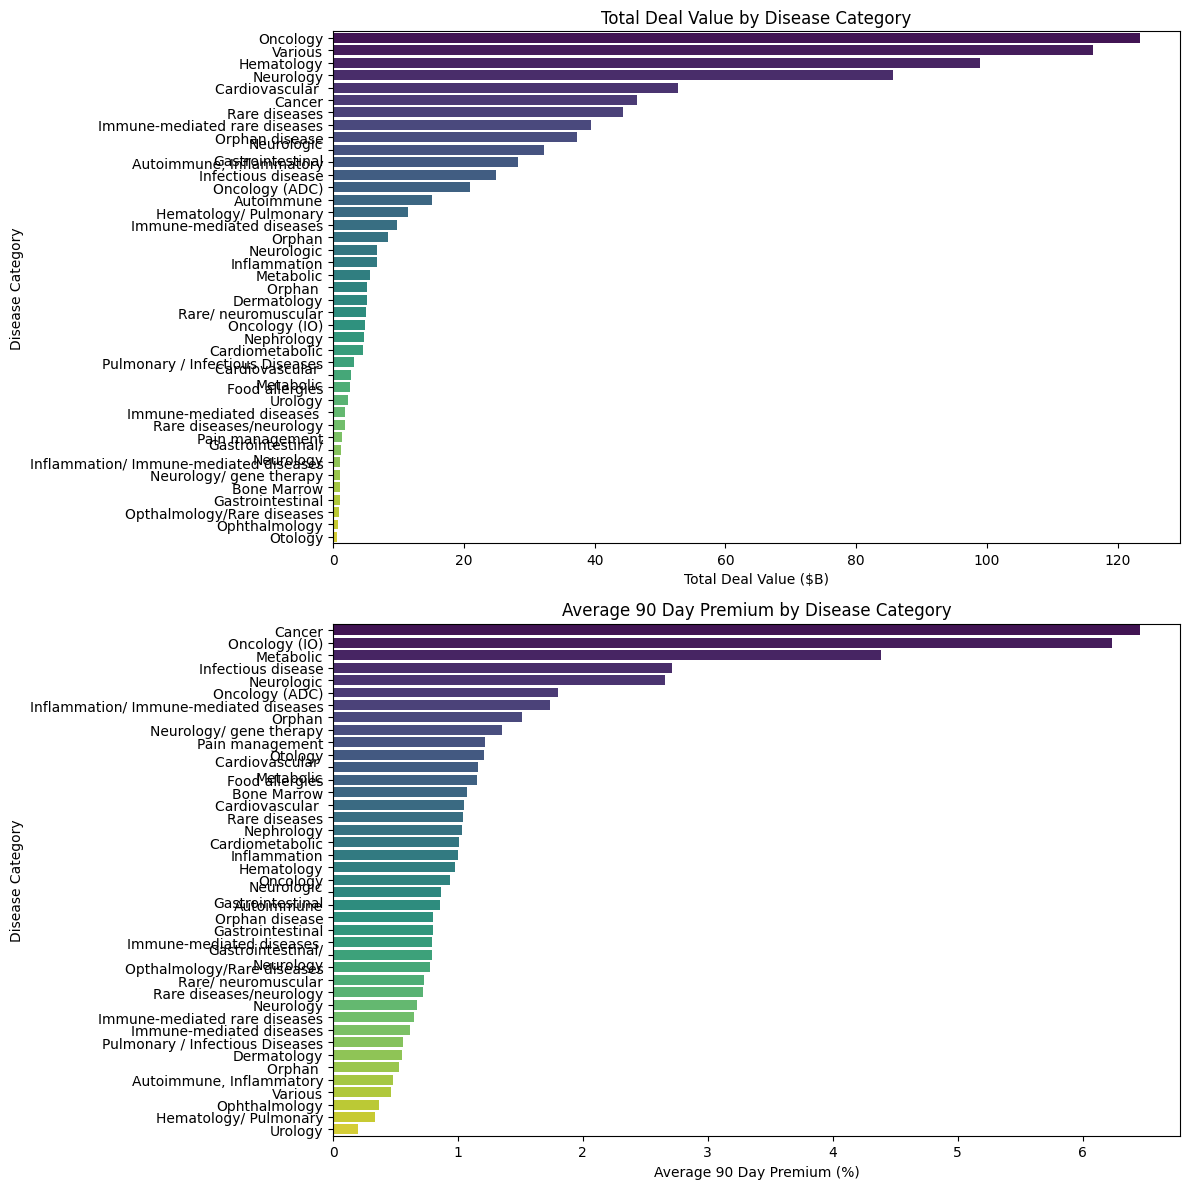

In [16]:
# Group by Disease Category and calculate totals
disease_grouped = df_clean_90.groupby('Disease Category').agg(
    Total_Deal_Value=('Deal Value \n($B)', 'sum'),
    Average_90_Day_Premium=('90 Day Premium', 'mean')
).reset_index()

# Sort the grouped data by Total Deal Value
disease_grouped = disease_grouped.sort_values(by='Total_Deal_Value', ascending=False)

# Plotting Total Deal Value and Average 90 Day Premium for Disease Category
plt.figure(figsize=(12, 12))

# 1. Bar plot for Total Deal Value by Disease Category
plt.subplot(2, 1, 1)
sns.barplot(data=disease_grouped, x='Total_Deal_Value', y='Disease Category', palette='viridis')
plt.xlabel('Total Deal Value ($B)')
plt.title('Total Deal Value by Disease Category')

# 2. Average 90 Day Premium by Disease Category
plt.subplot(2, 1, 2)
sns.barplot(data=disease_grouped.sort_values(by='Average_90_Day_Premium', ascending=False), 
            x='Average_90_Day_Premium', y='Disease Category', palette='viridis')
plt.xlabel('Average 90 Day Premium (%)')
plt.title('Average 90 Day Premium by Disease Category')

plt.tight_layout()
plt.show()


## Deal Structure  vs 90 day Premium & Deal Size
#### All cash deals are great in total deal value and average 90 day premium.

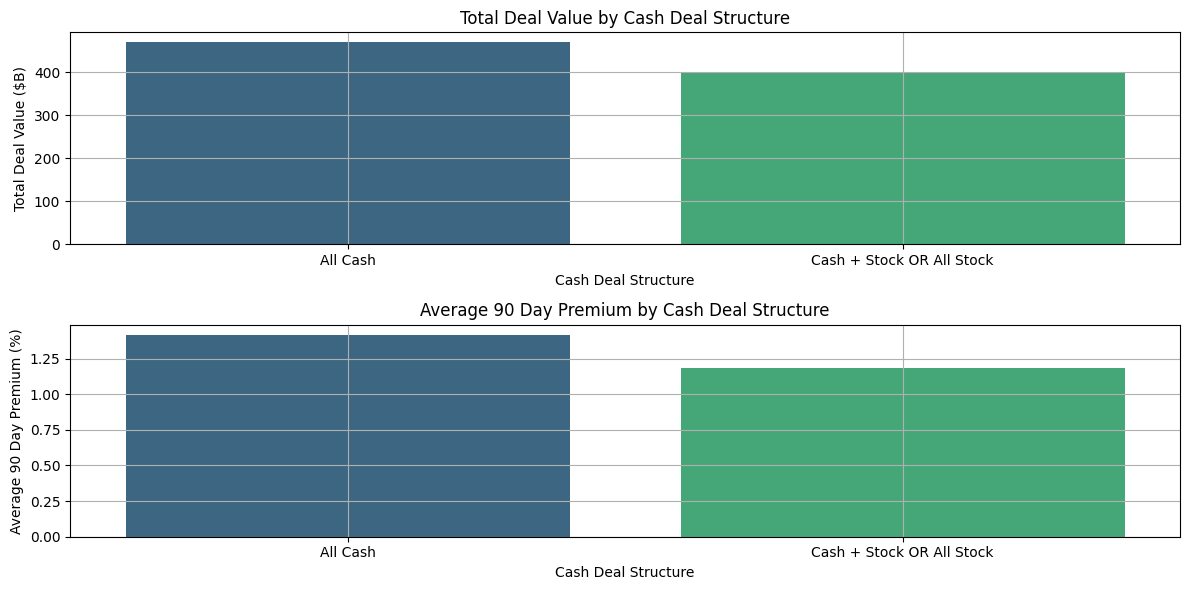

In [17]:
# Create a new column to classify the deal structure
df_clean_90['Cash Deal Structure'] = np.where(df_clean_90['Cash / Stock Deal Structure'] == 'All Cash', 'All Cash', 'Cash + Stock OR All Stock')

# Group by Cash Deal Structure and calculate totals
deal_structure_grouped = df_clean_90.groupby('Cash Deal Structure').agg(
    Total_Deal_Value=('Deal Value \n($B)', 'sum'),
    Average_90_Day_Premium=('90 Day Premium', 'mean')
).reset_index()

# Create a line plot for Total Deal Value and Average 90 Day Premium by Cash Deal Structure
plt.figure(figsize=(12, 6))

# 1. Line chart for Total Deal Value by Cash Deal Structure
plt.subplot(2, 1, 1)
sns.barplot(data=deal_structure_grouped, x='Cash Deal Structure', y='Total_Deal_Value', palette='viridis')
plt.xlabel('Cash Deal Structure')
plt.ylabel('Total Deal Value ($B)')
plt.title('Total Deal Value by Cash Deal Structure')
plt.grid(True)

# 2. Line chart for Average 90 Day Premium by Cash Deal Structure
plt.subplot(2, 1, 2)
sns.barplot(data=deal_structure_grouped, x='Cash Deal Structure', y='Average_90_Day_Premium', palette='viridis')
plt.xlabel('Cash Deal Structure')
plt.ylabel('Average 90 Day Premium (%)')
plt.title('Average 90 Day Premium by Cash Deal Structure')
plt.grid(True)

plt.tight_layout()
plt.show()


# Takeout Forward P/E Ratio vs Deal Size & Premium

#### Larger deals tend to have lower forward P/E ratios.
#### Higher premiums are linked to higher forward P/E ratios.

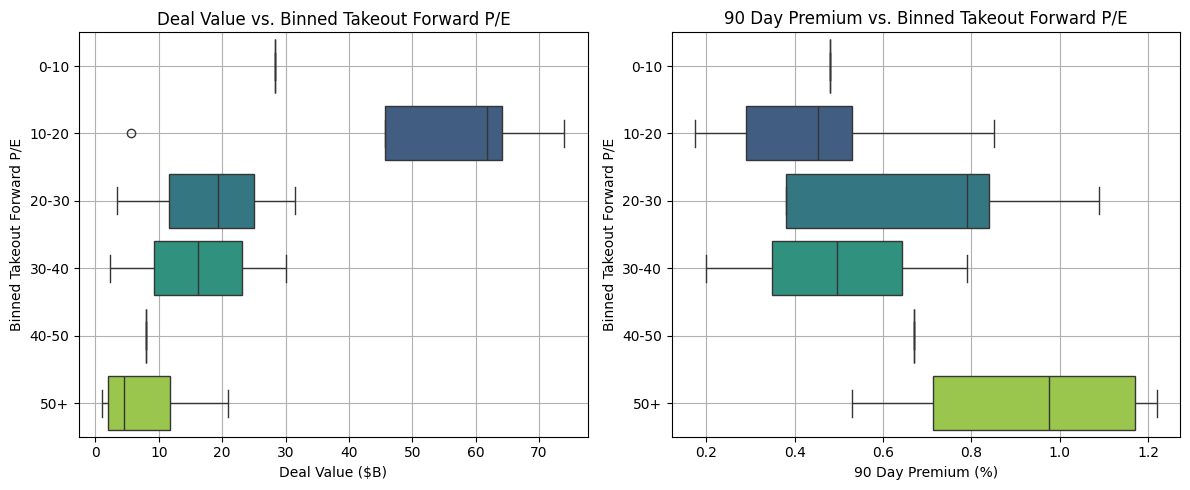

Correlation between Deal Value and Takeout Forward P/E: -0.40
Correlation between 90 Day Premium and Takeout Forward P/E: 0.55


In [18]:
# Remove rows with NaN values from relevant columns
df_clean_PE = df_clean_90.dropna(subset=['Deal Value \n($B)', '90 Day Premium', 'Takeout Forward P/E'])

# Convert 'Takeout Forward P/E' to numeric, forcing errors to NaN
df_clean_PE['Takeout Forward P/E'] = pd.to_numeric(df_clean_PE['Takeout Forward P/E'], errors='coerce')

# Drop any rows where 'Takeout Forward P/E' is now NaN
df_clean_PE = df_clean_PE.dropna(subset=['Takeout Forward P/E'])

# Create bins for Takeout Forward P/E
bins = [0, 10, 20, 30, 40, 50, np.inf]
labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50+']
df_clean_PE['P/E Binned'] = pd.cut(df_clean_PE['Takeout Forward P/E'], bins=bins, labels=labels)

# Create a scatter plot for Deal Value vs. Binned Takeout Forward P/E (using boxplot for visualization)
plt.figure(figsize=(12, 5))

# Box plot for Deal Value vs. Binned Takeout Forward P/E
plt.subplot(1, 2, 1)
sns.boxplot(data=df_clean_PE, x='Deal Value \n($B)', y='P/E Binned', palette='viridis')
plt.title('Deal Value vs. Binned Takeout Forward P/E')
plt.xlabel('Deal Value ($B)')
plt.ylabel('Binned Takeout Forward P/E')
plt.grid(True)

# Box plot for 90 Day Premium vs. Binned Takeout Forward P/E
plt.subplot(1, 2, 2)
sns.boxplot(data=df_clean_PE, x='90 Day Premium', y='P/E Binned', palette='viridis')
plt.title('90 Day Premium vs. Binned Takeout Forward P/E')
plt.xlabel('90 Day Premium (%)')
plt.ylabel('Binned Takeout Forward P/E')
plt.grid(True)

plt.tight_layout()
plt.show()

# Calculate and display the correlation coefficients
correlation_deal_pe = df_clean_PE['Deal Value \n($B)'].corr(df_clean_PE['Takeout Forward P/E'])
correlation_premium_pe = df_clean_PE['90 Day Premium'].corr(df_clean_PE['Takeout Forward P/E'])

print(f"Correlation between Deal Value and Takeout Forward P/E: {correlation_deal_pe:.2f}")
print(f"Correlation between 90 Day Premium and Takeout Forward P/E: {correlation_premium_pe:.2f}")

# GET XBI DATA

In [19]:
# Define the ticker symbol and file path # SINCE 2006
ticker_symbol = 'XBI'
file_path = 'xbi_data.csv'

# Check if the file exists
if os.path.exists(file_path):
    # Read the data from the CSV file
    data_xbi = pd.read_csv(file_path, index_col='Date', parse_dates=True)
    print("Data loaded from CSV.")
else:
    # Download historical data
    data_xbi = yf.download(ticker_symbol, period='max', interval='1d')
    # Save the data to a CSV file
    data_xbi.to_csv(file_path)
    print("Data downloaded and saved to CSV.")

data_xbi.reset_index(inplace=True)

# Convert date column to datetime format if necessary
data_xbi['Date'] = pd.to_datetime(data_xbi['Date'])

Data loaded from CSV.


## Analyze price movements around deal dates - 1 month before and after

In [20]:
# Convert 'Date' to datetime format
data_xbi['Date'] = pd.to_datetime(data_xbi['Date'])

# Set 'Date' as the index
data_xbi.set_index('Date', inplace=True)

# Resample to monthly frequency, calculating the mean close price for each month
monthly_avg = data_xbi['Close'].resample('M').mean()

# Calculate the percentage change month-over-month
monthly_change = monthly_avg.pct_change() * 100  # Convert to percentage

# Calculate the average monthly change
average_monthly_change_PERCENT_XBI = monthly_change.mean()

# Display the results
print("Average Monthly Change in XBI (%):", average_monthly_change_PERCENT_XBI)

data_xbi.reset_index(inplace=True)


Average Monthly Change in XBI (%): 0.9987324448548616


### Positive Signifcant if change is > Average Monthly Change
### Negative Signifcant if change is < - (Average Monthly Change)
### Not Signifcant if change is between the above 2 values

Comparison of Deal Characteristics by Movement Type:
Deal Value 
($B): Positive Significant=24.27, Negative Significant=21.67
90 Day Premium: Positive Significant=0.74, Negative Significant=0.60
Takeout Forward P/E: Positive Significant=54.24, Negative Significant=31.13


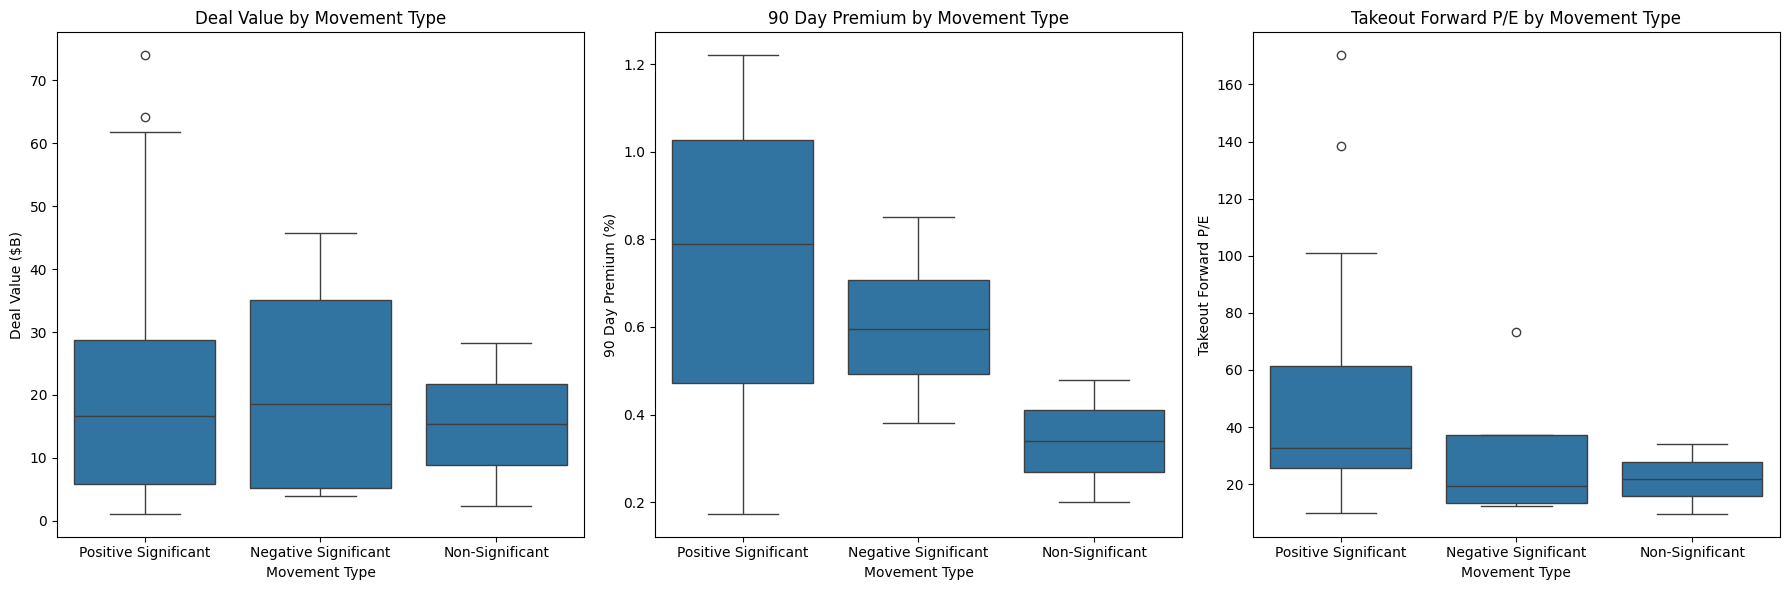

In [21]:
# Define a window around the deal date for analysis
WINDOW_DAYS = 30  # 1 month before and after
deal_dates = df_clean["Date Announced"].unique()

def calculate_price_changes(deal_dates, data_xbi):
    """Calculate average price changes around deal dates."""
    price_changes = []
    
    for date in deal_dates:
        # Define the window around the deal date
        window_start = date - timedelta(days=WINDOW_DAYS)
        window_end = date + timedelta(days=WINDOW_DAYS)

        # Get prices before and after the deal within the defined window
        before_prices = data_xbi[(data_xbi['Date'] >= window_start) & (data_xbi['Date'] < date)]['Close']
        after_prices = data_xbi[(data_xbi['Date'] > date) & (data_xbi['Date'] <= window_end)]['Close']

        # Calculate average prices before and after the deal
        if not before_prices.empty and not after_prices.empty:
            before_avg = before_prices.mean()
            after_avg = after_prices.mean()
            change = ((after_avg - before_avg) / before_avg) * 100
            
            # Append results to list with movement type
            price_changes.append({
                'Date': date,
                'Price Change (%)': change,
                'Movement Type': 'Positive Significant' if change > average_monthly_change_PERCENT_XBI else 
                                 'Negative Significant' if change < -average_monthly_change_PERCENT_XBI else 
                                 'Non-Significant'
            })
    
    return pd.DataFrame(price_changes)

def clean_and_convert(df, columns):
    """Convert specified columns to numeric, handling errors."""
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df.dropna(subset=columns)

def analyze_movement_differences(df_clean, price_changes_df):
    """Analyze differences in deals based on positive or negative significant XBI movements."""
    # Merge price changes with original deal data
    merged_df = df_clean.merge(price_changes_df, left_on='Date Announced', right_on='Date')

    # Convert relevant columns to numeric
    merged_df = clean_and_convert(merged_df, ['Deal Value \n($B)', '90 Day Premium', 'Takeout Forward P/E'])

    # Separate deals into three groups: Positive Significant, Negative Significant, Non-Significant movements
    positive_significant_deals = merged_df[merged_df['Movement Type'] == 'Positive Significant']
    negative_significant_deals = merged_df[merged_df['Movement Type'] == 'Negative Significant']

    # Compare average values of key metrics
    comparison_metrics = ['Deal Value \n($B)', '90 Day Premium', 'Takeout Forward P/E']
    comparison_results = {}

    for metric in comparison_metrics:
        avg_positive_significant = positive_significant_deals[metric].mean()
        avg_negative_significant = negative_significant_deals[metric].mean()
        comparison_results[metric] = {'Positive Significant': avg_positive_significant, 'Negative Significant': avg_negative_significant}

    print("Comparison of Deal Characteristics by Movement Type:")
    for metric, values in comparison_results.items():
        print(f"{metric}: Positive Significant={values['Positive Significant']:.2f}, Negative Significant={values['Negative Significant']:.2f}")

    # Visualization
    visualize_movement_comparison(merged_df)

def visualize_movement_comparison(merged_df):
    """Create visualizations to compare positive and negative significant movements."""
    plt.figure(figsize=(18, 6))

    # Deal Value
    plt.subplot(1, 3, 1)
    sns.boxplot(x='Movement Type', y='Deal Value \n($B)', data=merged_df)
    plt.title('Deal Value by Movement Type')
    plt.xlabel('Movement Type')
    plt.ylabel('Deal Value ($B)')

    # 90 Day Premium
    plt.subplot(1, 3, 2)
    sns.boxplot(x='Movement Type', y='90 Day Premium', data=merged_df)
    plt.title('90 Day Premium by Movement Type')
    plt.xlabel('Movement Type')
    plt.ylabel('90 Day Premium (%)')

    # Takeout Forward P/E
    plt.subplot(1, 3, 3)
    sns.boxplot(x='Movement Type', y='Takeout Forward P/E', data=merged_df)
    plt.title('Takeout Forward P/E by Movement Type')
    plt.xlabel('Movement Type')
    plt.ylabel('Takeout Forward P/E')

    plt.tight_layout()
    plt.show()

# Main analysis workflow
price_changes_df = calculate_price_changes(deal_dates, data_xbi)

# Analyze differences in deals based on movement type
analyze_movement_differences(df_clean, price_changes_df)

The box plots provide a visual comparison of how different types of deal characteristics affect the XBI index. 

### **Deal Value ($B)**

- **Positive Significant**: Deals that lead to a significant positive movement in the XBI index have an average value of $24.27 billion.
- **Negative Significant**: Deals causing a significant negative movement average $21.67 billion.
- **Interpretation**: Larger deals, whether they cause the index to rise or fall significantly, tend to have a big impact on the market.

### **90 Day Premium**

- **Positive Significant**: Deals with a significant positive impact have a higher average premium of 0.74.
- **Negative Significant**: Deals with a negative impact have a slightly lower premium of 0.60.
- **Interpretation**: Higher premiums are often linked to positive market reactions, indicating that investors see more potential value in these deals.

### **Takeout Forward P/E**

- **Positive Significant**: Deals that positively impact the index have a higher forward P/E ratio of 54.24, indicating strong growth expectations.
- **Negative Significant**: Those with negative impacts have a lower forward P/E ratio of 31.13.
- **Interpretation**: Higher growth expectations (forward P/E) are associated with positive movements, while lower expectations can lead to negative movements.

### **Visual Insights**

- **Deal Value by Movement Type**: Shows that larger deals are associated with both positive and negative significant movements, highlighting their market influence.
- **90 Day Premium by Movement Type**: Indicates that positive movements are more closely tied to higher premiums, reflecting investor optimism.
- **Takeout Forward P/E by Movement Type**: Demonstrates that higher growth expectations drive positive movements.

### **Overall Analysis**

These results suggest that larger deals with higher premiums and growth expectations are more likely to cause significant movements in the XBI index, whether up or down. This information helps identify which types of biotech M&A deals are likely to influence the index significantly, aiding in strategic decision-making for event-driven trading strategies.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

September/October Performance for 2023: {'AADI': np.float64(-0.003109300171007108), 'ABCL': np.float64(-0.003985374472203462), 'ABOS': np.float64(-0.018056193183909334), 'ABVC': np.float64(-0.003074871744674017), 'ACAD': np.float64(-0.003967684914446716), 'ACET': np.float64(-0.0055538861572693235), 'ACHL': np.float64(0.004729676286731977), 'ACRV': np.float64(-0.01526949738066578), 'ACXP': np.float64(0.01858517515890784), 'ADAP': np.float64(-0.009840382878957197), 'ADCT': np.float64(-0.00665687503428664), 'ADIL': np.float64(-0.010729411819357552), 'ADPT': np.float64(-0.003975463381508657), 'ADTX': np.float64(-0.06661926003435958), 'ADXN': np.float64(-0.004555621989310314), 'AFMD': np.float64(-0.008428393728564139), 'AGEN': np.float64(-0.008390294773499429), 'AIM': np.float64(-0.007076570336299163), 'AKRO': np.float64(-0.014075846564539135), 'AKTX': np.float64(-0.001791021047407704), 'ALDX': np.float64(-0.01589427751779783), 'ALEC': np.float64(-0.0003494225100608979), 'ALGS': np.float64(

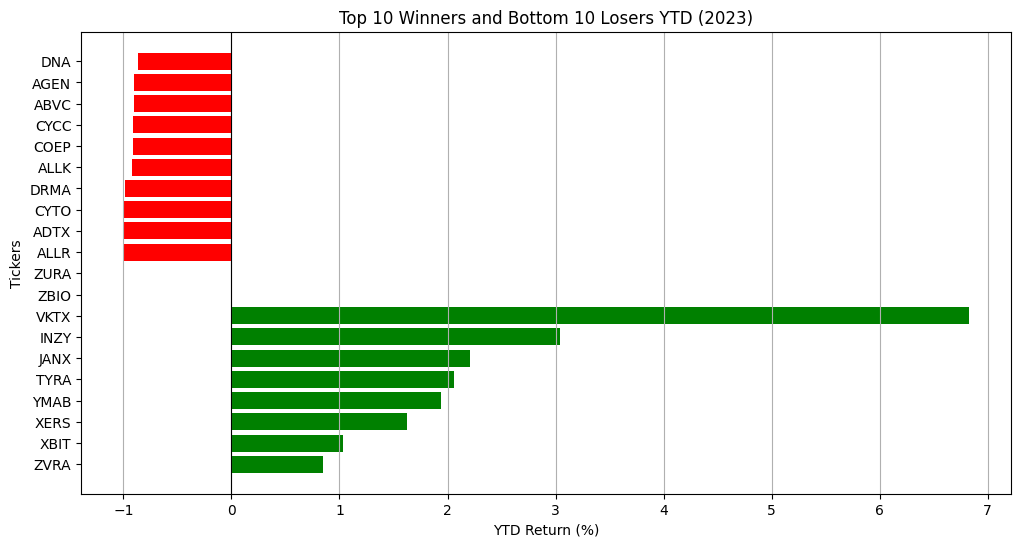

In [22]:
# #2023 ANALYSIS
# # Function to fetch biotech tickers
# def get_biotech_tickers():
#     df_biotech_tickers = pd.read_csv("biotech_tickers.csv")
#     tickers = df_biotech_tickers.Ticker.unique()  # Adjust as needed
#     return tickers.tolist()  # Convert to list

# # Download YTD price data for biotech tickers or load from CSV
# def get_ytd_data(tickers, save_path='ytd_data_2023.csv'):
#     if os.path.exists(save_path):
#         # Load existing data
#         data = pd.read_csv(save_path, index_col=0, parse_dates=True)
#         return data
    
#     start_date = '2023-01-01'
#     end_date = datetime.now().strftime('%Y-%m-%d')
#     print("Fetching data for tickers:", tickers)  # Debugging output
#     data = yf.download(tickers, start=start_date, end=end_date)['Close']

#     # Save the downloaded data to a CSV file
#     data.to_csv(save_path)
#     return data

# # Analyze YTD Performance
# def analyze_ytd_performance(ytd_data):
#     performance = {}
#     for ticker, prices in ytd_data.items():
#         if len(prices) >= 2:  # Check if there are at least two prices
#             ytd_return = (prices[-1] - prices[0]) / prices[0]
#             performance[ticker] = ytd_return
#     return performance

# # Get historical data for specific tickers
# def get_historical_data(ticker, start_date, end_date):
#     return yf.download(ticker, start=start_date, end=end_date)['Close']

# # Analyze the performance of YTD losers in given months
# def analyze_monthly_performance(ytd_performance, month_start, month_end):
#     losers = [ticker for ticker, return_val in ytd_performance.items() if return_val < 0]
#     month_performance = {}
    
#     for ticker in losers:
#         # Get historical data for the specified months
#         prices = get_historical_data(ticker, '2023-01-01', datetime.now().strftime('%Y-%m-%d'))
        
#         # Calculate daily returns
#         month_returns = prices.pct_change().dropna()

#         # Filter returns for September and October
#         month_returns_filtered = month_returns[month_returns.index.month.isin([month_start, month_end])]
#         if not month_returns_filtered.empty:
#             month_performance[ticker] = month_returns_filtered.mean()  # Average monthly return
    
#     return month_performance

# # Statistical significance testing
# def statistical_significance(month_performance):
#     returns = list(month_performance.values())
#     if returns:  # Check if there are returns to analyze
#         t_stat, p_value = stats.ttest_1samp(returns, 0)
#         return t_stat, p_value
#     else:
#         return None, None  # No returns to analyze

# # Plotting Function for Winners and Losers
# def plot_winners_and_losers(performance):
#     sorted_performance = sorted(performance.items(), key=lambda item: item[1])
    
#     # Get top 10 winners and bottom 10 losers
#     bottom_10_losers = sorted_performance[:10]
#     top_10_winners = sorted_performance[-10:]

#     # Prepare data for plotting
#     tickers = [item[0] for item in top_10_winners + bottom_10_losers]
#     returns = [item[1] for item in top_10_winners + bottom_10_losers]

#     plt.figure(figsize=(12, 6))
#     bar_colors = ['green' if r >= 0 else 'red' for r in returns]
#     plt.barh(tickers, returns, color=bar_colors)
    
#     plt.axvline(0, color='black', linewidth=0.8)  # Line at y=0 for reference
#     plt.title('Top 10 Winners and Bottom 10 Losers YTD (2023)')
#     plt.xlabel('YTD Return (%)')
#     plt.ylabel('Tickers')
#     plt.grid(axis='x')
#     plt.show()

# # Main Analysis Workflow
# biotech_tickers = get_biotech_tickers()
# ytd_data = get_ytd_data(biotech_tickers)
# ytd_performance = analyze_ytd_performance(ytd_data)

# # Analyze performance for September and October
# sep_oct_performance = analyze_monthly_performance(ytd_performance, 9, 10)
# t_stat, p_value = statistical_significance(sep_oct_performance)

# # Output results
# print("September/October Performance for 2023:", sep_oct_performance)
# if t_stat is not None and p_value is not None:
#     print("Statistical Test: t-statistic =", t_stat, ", p-value =", p_value)
# else:
#     print("No sufficient data for statistical analysis.")

# # Plot Winners and Losers
# plot_winners_and_losers(ytd_performance)


Statistical Significance: The results are statistically significant. This means that there is strong evidence to suggest that the average return of the YTD losers during September and October is significantly less than zero.

This implies that the stocks which performed poorly over the year (up to this point) tend to continue to perform poorly during these specific months, suggesting a negative trend or persistent underperformance among these stocks.